<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 47

# Student 1: Ahmet Ayrancioglu
# Student 2: Ricardo Andrade
# Student 3: Ruben Wolters


# Imports

In [ ]:
!pip install pytorch-lightning --quiet
!pip install torchmetrics==0.8.2 --quiet

     |████████████████████████████████| 585 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 140 kB 68.4 MB/s 
     |████████████████████████████████| 419 kB 66.9 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 271 kB 64.3 MB/s 
     |████████████████████████████████| 144 kB 70.5 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 409 kB 4.1 MB/s 


In [ ]:
import numpy as np
import pickle
import requests
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning import loggers as pl_loggers
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt


pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Explanation of the Notebook

In [ ]:
# AUTO ENCODERS
# 1. Use the first dataset with autoencoders to learn the distribution and to create embeddings. Dense networks.
# 2. Use the 2nd dataset to train a classifier using the embeddings from the first model. So encoder + dense network
# 3. Remove the noise from the 3rd and 4th dataset with the first model. 
#     To use autoencoders for anomaly detection, use reconstruction error (MSE) and find a threshold for anomalies.
# 4. Classify them using the 2nd model (classifier)

# Data loading and inspection

In [ ]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

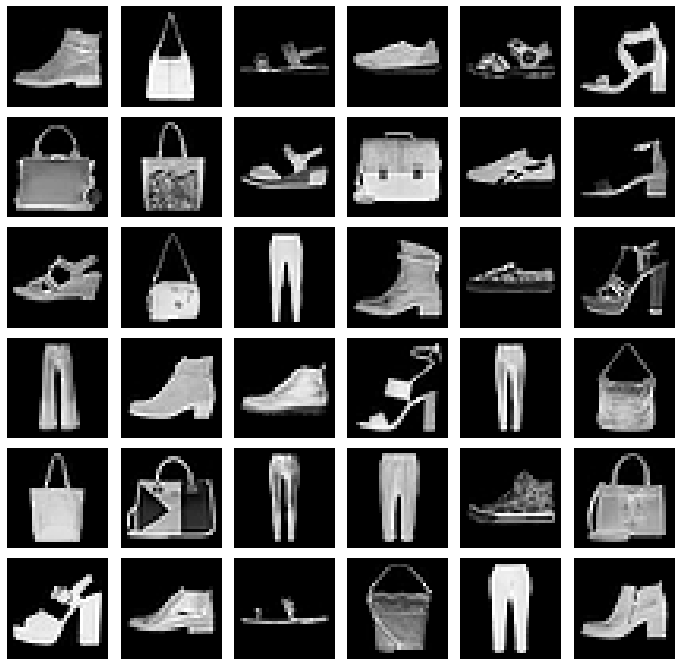

In [ ]:
# plot some samples from the dataset
def plot_samples(count, dataset):
    ncols = 6
    len_data = len(dataset)
    nrows = int(count / ncols) + np.sign(count % ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    sample_indices = np.random.choice(range(len_data), count, replace=False)

    samples = dataset[sample_indices]
    samples = np.squeeze(samples)

    axs = axs.flatten()
    for i, sample in enumerate(samples):
      ax = axs[i]
      ax.axis('off')
      ax.imshow(sample, cmap='gray')

    fig.subplots_adjust(wspace=0.1, hspace=0.1)

plot_samples(36, full_data['representative_set_1']['data'])

# Data Handling and Preprocessing

In [ ]:
# ===================== autoencoder =========================

class AutoEncoderDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X)
        
  def __getitem__(self, index):
    x = self.X[index]
    return x
  
  def __len__(self):
    return len(self.X)


class AutoEncoderDataModule(pl.LightningDataModule):
  def __init__(self,
               data_train,
               batch_size
               ):
    super().__init__()
    self.batch_size = batch_size
    
    self.data_train = data_train

  # Convert the pixel values to values in range [0,1] to make the model converge
  def preprocess(self, X):
    X = X.astype("float32")
    X = X / 255
    return X

  def setup(self, stage=None):
    X_train = self.preprocess(self.data_train)
    self.train = AutoEncoderDataset(X_train)

  def train_dataloader(self):
    return DataLoader(self.train, batch_size=self.batch_size, num_workers=2, pin_memory=True)

  def predict_dataloader(self):
    return DataLoader(self.train, batch_size=self.batch_size, num_workers=2, pin_memory=True)



In [ ]:
# ===================== classifier =========================

class ClassifierDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)
        
  def __getitem__(self, index):
    x = self.X[index]
    y = self.y[index]
    return x, y
  
  def __len__(self):
    return len(self.X)


class ClassifierDataModule(pl.LightningDataModule):
  def __init__(self,
               X_train, y_train,
               X_valid, y_valid,
              #  X_test, y_test,
               batch_size
               ):
    super().__init__()
    self.batch_size = batch_size
    
    self.X_train = X_train
    self.X_valid = X_valid
    # self.X_test = X_test

    self.y_train = y_train
    self.y_valid = y_valid
    # self.y_test = y_test

  # Convert the pixel values to values in range [0,1] to make the model converge
  def preprocess(self, X):
    X = X.astype("float32")
    X = X / 255
    return X

  # Convert the one hot encoded labels to integer values in order to use CrossEntropyLoss
  def encode_label(self, y):
    y = np.argmax(y, axis=1)
    return y

  def setup(self, stage=None):
    self.train = ClassifierDataset(self.preprocess(self.X_train), self.encode_label(self.y_train))
    self.valid = ClassifierDataset(self.preprocess(self.X_valid), self.encode_label(self.y_valid))
    # self.test = ClassifierDataset(self.preprocess(self.X_test), self.encode_label(self.y_test))

  def train_dataloader(self):
    return DataLoader(self.train, batch_size=self.batch_size, num_workers=2, pin_memory=True)

  def val_dataloader(self):
    return DataLoader(self.valid, batch_size=self.batch_size, num_workers=2, pin_memory=True)

  # remove this and make the prediction using the datasets it self
  # def predict_dataloader(self):
    # return DataLoader(self.test, batch_size=self.batch_size, num_workers=2, pin_memory=True)



# Model definitions

In [ ]:
# ===================== autoencoder =========================


class AutoEncoder(nn.Module):
  def __init__(self, input_dims, latent_size):
    super().__init__()

    self.input_dims = input_dims
    self.input_size = np.prod(input_dims)
    self.flatten = nn.Flatten()
    self.unflatten = nn.Unflatten(1, input_dims)

    self.encoder = nn.Sequential(
      nn.Linear(in_features=self.input_size, out_features=32),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=32, out_features=16),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=16, out_features=latent_size),
      nn.ReLU(inplace=True),
    )

    self.decoder = nn.Sequential(
      nn.Linear(in_features=latent_size, out_features=16),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=16, out_features=32),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=32, out_features=self.input_size),
      nn.Sigmoid(),
    )

  def forward(self, x):
    # First flatten the input to put it through a dense network
    x_flat = self.flatten(x)

    # encode
    enc_out = self.encoder(x_flat)

    # decode
    dec_out = self.decoder(enc_out)

    # unflatten to get the image back
    x_hat = self.unflatten(dec_out)

    return x_hat


class AutoEncoderSystem(pl.LightningModule):
  def __init__(self, input_dims, latent_size):
    super().__init__()

    # loss and model
    self.loss = nn.MSELoss()
    self.model = AutoEncoder(input_dims, latent_size)

  def forward(self, X):
    out = self.model(X)
    return out

  def training_step(self, batch, batch_idx):
    X = batch
    X_hat = self(X)
    loss = self.loss(X, X_hat)

    self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def predict_step(self, batch, batch_idx):
    X = batch
    X_hat = self(X)
    return X_hat

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2)
    return optimizer



In [ ]:
# ===================== classifier =========================


class Classifier(nn.Module):
  def __init__(self, encoder, latent_size, output_size):
    super().__init__()

    # size params
    self.output_size = output_size
    self.latent_size = latent_size

    # encoder for the embeddings
    self.encoder = encoder

    # to flatten the image for the encoder
    self.flatten = nn.Flatten()

    # dense layer for classification
    self.dense = nn.Sequential(
      nn.Linear(in_features=self.latent_size, out_features=32),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=32, out_features=32),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=32, out_features=self.output_size),
      nn.Softmax(),
    )


  def forward(self, x):
    # flatten
    x_flat = self.flatten(x)

    # encode to get embeddings
    x_embed = self.encoder(x_flat)

    # classification dense network
    y = self.dense(x_embed)
    return y


class ClassifierSystem(pl.LightningModule):
  def __init__(self, encoder, latent_size, output_size):
    super().__init__()

    # loss and model
    self.loss = nn.CrossEntropyLoss()
    self.model = Classifier(encoder, latent_size, output_size)

  def forward(self, X):
    out = self.model(X)
    return out

  def training_step(self, batch, batch_idx):
    X, y = batch
    y_pred = self(X)
    loss = self.loss(y_pred, y)
    acc = torch.sum(y == torch.argmax(y_pred, dim=1)) / len(y)

    self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    X, y = batch
    y_pred = self(X)
    loss = self.loss(y_pred, y)
    acc = torch.sum(y == torch.argmax(y_pred, dim=1)) / len(y)

    self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def predict_step(self, batch, batch_idx):
    X, y = batch
    y_pred = self(X)

    return y_pred

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
    return optimizer



# Training and validation loop

In [ ]:
def calculate_threshold(trainer, datamodule):
  # original input
  X = datamodule.train_dataloader().dataset.X

  # output of the auto encoder
  X_hat = trainer.predict(datamodule=datamodule, ckpt_path='best')

  # concat the batches
  X_hat = torch.concat(X_hat)

  # MSE loss to be used for threshold
  loss = nn.MSELoss(reduction='none')

  # flatten the images in order to make loss calculation easier
  losses = torch.mean(
      loss(torch.flatten(X, 1), torch.flatten(X_hat, 1)),
      dim=-1
      ) 

  # threshold is the mean of all losses + one standard deviation
  threshold = losses.mean() + 3 * losses.std()

  return threshold


def detect_outliers(trainer, datamodule, threshold):
  # get the data into a data module and setup up
  datamodule.setup()

  # get the input from the data module
  X = datamodule.train.X

  # output of the auto encoder
  X_hat = trainer.predict(datamodule=datamodule, ckpt_path='best')

  # concat the batches
  X_hat = torch.concat(X_hat)

  # MSE loss to be used for threshold
  loss = nn.MSELoss(reduction='none')

  # flatten the images in order to make loss calculation easier
  losses = torch.mean(
      loss(torch.flatten(X, 1), torch.flatten(X_hat, 1)),
      dim=-1
      )
  return losses > threshold 

## Autoencoder

In [ ]:
# Dataset
unlabeled_data = AutoEncoderDataModule(full_data['unlabeled_data'], 64)

# Model
# 1 x 32 x 32
input_dims = full_data['unlabeled_data'][0].shape
auto_encoder_model = AutoEncoderSystem(input_dims=input_dims, latent_size=16)

# logger
logger = CSVLogger("logs", name="ass-4-ae", version=1)

# Trainer
auto_encoder_trainer = pl.Trainer(
      accelerator="gpu",
      devices=1,
      max_epochs=20,
      log_every_n_steps=100,
      logger=logger,
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Training
auto_encoder_trainer.fit(auto_encoder_model, unlabeled_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | loss  | MSELoss     | 0     
1 | model | AutoEncoder | 68.2 K
--------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

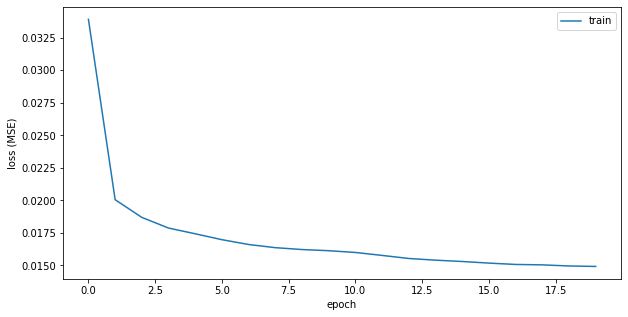

In [ ]:
# Plot the training loss
metric_df: pd.DataFrame = pd.read_csv("/content/logs/ass-4-ae/version_1/metrics.csv")
ax = metric_df.fillna(method='ffill').plot(x='epoch', y='train_loss', xlabel='epoch', ylabel='loss (MSE)', label='train', figsize=(10,5))

## Classifier

In [ ]:
# move this inside the below cell
def remove_outliers(X, y, outliers):
  return X[~outliers], y[~outliers]

def get_test_set(i):
  test_sets = ['representative_set_1', 'representative_set_2']
  test_set = test_sets[i]
  return full_data[test_set]['data'], full_data[test_set]['labels']


In [ ]:
# Dataset

# split the dataset into train and valid.
X_train, y_train = full_data['labeled_data']['data'], full_data['labeled_data']['labels']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# the final datamodule
classifier_data = ClassifierDataModule(X_train, y_train, X_valid, y_valid, 32)

# Model
classifier_model = ClassifierSystem(encoder=auto_encoder_model.model.encoder, latent_size=16, output_size=6)

# logger
logger = CSVLogger("logs", name="ass-4-clf", version=1)

# Trainer
classifier_trainer = pl.Trainer(
      accelerator="gpu",
      devices=1,
      max_epochs=30,
      log_every_n_steps=100,
      check_val_every_n_epoch=5,
      logger=logger,
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Training
classifier_trainer.fit(classifier_model, classifier_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Classifier       | 35.4 K
-------------------------------------------
35.4 K    Trainable params
0         Non-trainable params
35.4 K    Total params
0.142     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (50) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

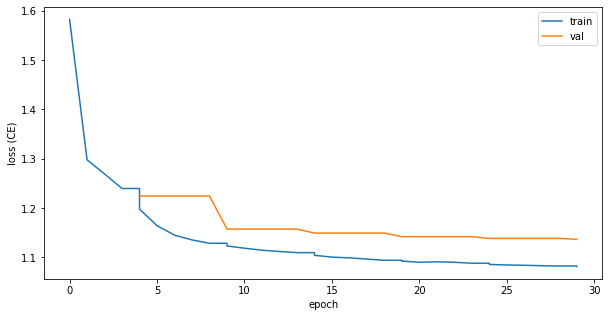

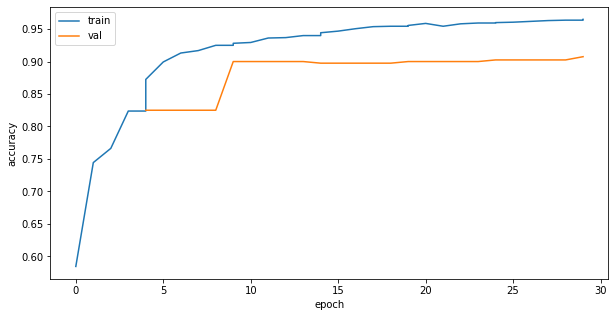

In [ ]:
# Plot the training loss
metric_df: pd.DataFrame = pd.read_csv("/content/logs/ass-4-clf/version_1/metrics.csv")
ax = metric_df.fillna(method='ffill').plot(x='epoch', y='train_loss', xlabel='epoch', ylabel='loss (CE)', label='train', figsize=(10,5))
ax = metric_df.fillna(method='ffill').plot(x='epoch', y='val_loss', ax=ax, label='val')


ax = metric_df.fillna(method='ffill').plot(x='epoch', y='train_accuracy', xlabel='epoch', ylabel='accuracy', label='train', figsize=(10,5))
ax = metric_df.fillna(method='ffill').plot(x='epoch', y='val_accuracy', ax=ax, label='val')

# Inspection, Validation, and Analysis

In [ ]:
def report_outlier_performance(auto_encoder_trainer, unlabeled_data, noisy_data_X, noisy_data_y):
  # calculate threshold
  threshold = calculate_threshold(auto_encoder_trainer, unlabeled_data)

  # put the data into the data module to go through the autoencoder
  outlier_data = AutoEncoderDataModule(noisy_data_X, 256)

  # find the indices of the outliers
  outliers = detect_outliers(auto_encoder_trainer, outlier_data, threshold)
  
  # actual outliers
  outlier_true = noisy_data_y[:, 5]

  # metrics
  print(f"threshold: {threshold:0.2f}")
  print(f"num predicted outliers: {outliers.sum()}")
  print(f"num actual outliers: {outlier_true.sum()}")
  print(classification_report(outlier_true, outliers))

test_data = get_test_set(1)
report_outlier_performance(auto_encoder_trainer, unlabeled_data, test_data[0], test_data[1])

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

threshold: 0.04
num predicted outliers: 45
num actual outliers: 52.0
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1000
         1.0       0.60      0.52      0.56        52

    accuracy                           0.96      1052
   macro avg       0.79      0.75      0.77      1052
weighted avg       0.96      0.96      0.96      1052



In [ ]:
def report_classification_performance(auto_encoder_trainer, classifier_trainer, unlabeled_data, noisy_data_X, noisy_data_y):

  # Convert the pixel values to values in range [0,1] to make the model converge
  def preprocess(X):
    X = X.astype("float32")
    X = X / 255
    return X

  # Convert the one hot encoded labels to integer values in order to use CrossEntropyLoss
  def encode_label(y):
    y = np.argmax(y, axis=1)
    return y

  # find the threshold and detect the outliers
  threshold = calculate_threshold(auto_encoder_trainer, unlabeled_data)
  outlier_data = AutoEncoderDataModule(noisy_data_X, 256)
  outliers = detect_outliers(auto_encoder_trainer, outlier_data, threshold)

  # remove the outliers
  X_test, y_test = remove_outliers(noisy_data_X, noisy_data_y, outliers)

  # turn it into a datalaoder
  test_set = ClassifierDataset(preprocess(X_test), encode_label(y_test))
  test_loader = DataLoader(test_set, batch_size=256, num_workers=2, pin_memory=True)

  # make predictions
  y_pred = classifier_trainer.predict(dataloaders=test_loader, ckpt_path='best')

  # turn one hot encoded labels to integers
  y_pred = torch.argmax(torch.concat(y_pred), dim=1)

  # get the actual labels
  y_true = encode_label(y_test)

  # metrics
  print(classification_report(y_true, y_pred, zero_division=0))

test_data = get_test_set(1)
report_classification_performance(auto_encoder_trainer, classifier_trainer, unlabeled_data, test_data[0], test_data[1])

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

Restoring states from the checkpoint path at logs/ass-4-clf/version_1/checkpoints/epoch=29-step=1500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-clf/version_1/checkpoints/epoch=29-step=1500.ckpt


Predicting: 50it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       200
           1       0.90      0.84      0.87       187
           2       0.85      0.89      0.87       200
           3       0.94      0.96      0.95       197
           4       0.89      0.91      0.90       198
           5       0.00      0.00      0.00        25

    accuracy                           0.90      1007
   macro avg       0.75      0.77      0.76      1007
weighted avg       0.88      0.90      0.89      1007



In [ ]:
test_data = get_test_set(0)
report_classification_performance(auto_encoder_trainer, classifier_trainer, unlabeled_data, test_data[0], test_data[1])

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

Restoring states from the checkpoint path at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-ae/version_1/checkpoints/epoch=19-step=8140.ckpt


Predicting: 407it [00:00, ?it/s]

Restoring states from the checkpoint path at logs/ass-4-clf/version_1/checkpoints/epoch=29-step=1500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/ass-4-clf/version_1/checkpoints/epoch=29-step=1500.ckpt


Predicting: 50it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.92      0.91      0.92       188
           2       0.92      0.92      0.92       200
           3       0.94      0.98      0.96       193
           4       0.94      0.97      0.96       200
           5       0.00      0.00      0.00        23

    accuracy                           0.93      1004
   macro avg       0.78      0.79      0.79      1004
weighted avg       0.91      0.93      0.92      1004

